In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import DataLoader

import sys

sys.path.append("../electric-properties-only")
sys.path.append("../end-to-end")
sys.path.append("../end-to-end-with-feedback")
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")

# from helpers_conv_nn_models import make_true_vs_predicted_figure
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN_PL import EndToEndConvNN_PL
from EndToEndConvNNWithFeedback_PL import EndToEndConvNNWithFeedback_PL
from ElectricPropertiesNN_PL import ElectricPropertiesNN_PL

## Load trained Models

In [3]:
models = pd.DataFrame()

#### Prepare dataset for dummy run to initialize LazyLayers

In [4]:
batch_size = 1000
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
original_dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
original_stats = pd.DataFrame.from_dict(original_dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
data_dir_name = "../../efish-physics-model/data/processed/data-2025_01_08-detection_noise_threshold"
# data_dir_name = "../../efish-physics-model/data/processed/data-2024_12_11-discrimination_dataset"
raw_dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
new_stats = pd.DataFrame.from_dict(dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
dset.worms_properties_stats = original_dset.worms_properties_stats
dset.worms_properties = (
    dset.worms_properties[:] * new_stats.loc["std"].to_numpy()
    + new_stats.loc["mean"].to_numpy()
    - original_stats.loc["mean"].to_numpy()
) / original_stats.loc["std"].to_numpy()
dloader = DataLoader(dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=12)

scale_data_dir_name = "../../efish-physics-model/data/processed/data-2024_12_20-discrimination_dataset-retrain_scale_rule"
raw_scale_dataset = pd.read_pickle(f"{scale_data_dir_name}/dataset.pkl")
scale_dset = ElectricImagesDataset(data_dir_name=scale_data_dir_name, fish_t=20, fish_u=30)

#### Load full end-to-end models

In [5]:
for folder in list(np.sort(glob.glob("../figures/stats-panel/full-model*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNN_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "full", "model": [model]}),
        ]
    ).reset_index(drop=True)

/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
# load the retrained scale model
# checkpoint_path = f"../electric-properties-only/retrain_scale/lightning_logs/version_4/checkpoints/epoch=599-step=21000.ckpt"
checkpoint_path = f"../electric-properties-only/retrain_scale/lightning_logs/version_6/checkpoints/epoch=999-step=35000.ckpt"
retrained_scale_model = ElectricPropertiesNN_PL.load_from_checkpoint(checkpoint_path)
retrained_scale_model.eval()
retrained_scale_model.freeze()
retrained_scale_model.cpu()

ElectricPropertiesNN_PL(
  (model): ElectricPropertiesNN(
    (sequence): Sequential(
      (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=2, out_features=10, bias=True)
      (2): ReLU()
      (3): Linear(in_features=10, out_features=20, bias=True)
      (4): ReLU()
      (5): Linear(in_features=20, out_features=10, bias=True)
      (6): ReLU()
      (7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [7]:
for i, folder in enumerate(list(np.sort(glob.glob("../figures/stats-panel/feedback-with-values*")))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    model.model.spatial_model = models.loc[i, "model"].model
    # model.model.spatial_model.linear.fc3.linear.weight = torch.nn.Parameter(models.loc[i, "model"].model.linear.fc3.linear.weight[:4].clone())
    model.model.feedback_model = retrained_scale_model.model
    
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_vals", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

for i, folder in enumerate(list(np.sort(glob.glob("../figures/stats-panel/feedback-with-estimates*")))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    model.model.spatial_model = models.loc[i, "model"].model
    # model.model.spatial_model.linear.fc3.linear.weight = torch.nn.Parameter(models.loc[i, "model"].model.linear.fc3.linear.weight[:4].clone())
    model.model.feedback_model = retrained_scale_model.model
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_esti", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

In [8]:
models = models[models["lambda_RC"] > 0].reset_index(drop=True)
# models = models[models["model_type"]=="full"].reset_index(drop=True)
models = models[models["model_type"]!="feedback_vals"].reset_index(drop=True)

In [9]:
models

,rand_seed,lambda_RC,model_type,model
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
5,113,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
6,113,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
7,113,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
8,113,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
9,113,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...


## Inspect discrimination data

In [10]:
eis = next(iter(dloader))[0]
distance_ids = raw_dataset["worms"]["dataframe"]["position_ys"]
max_mod = eis[:, :, 5, 6]
print(eis.shape, max_mod.shape)

torch.Size([168, 2, 20, 30]) torch.Size([168, 2])


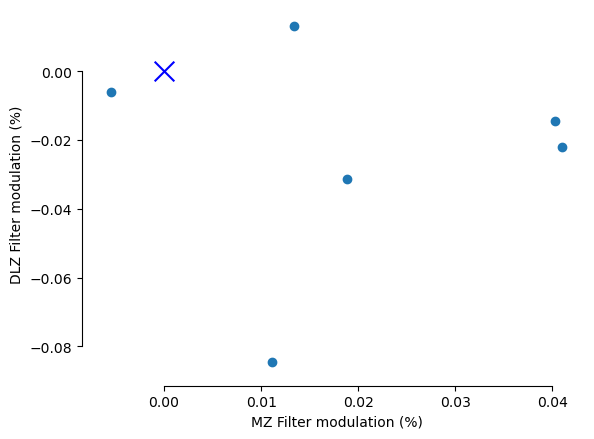

In [11]:
mask = raw_dataset["worms"]["dataframe"]["position_ys"] == 27
mask &= raw_dataset["worms"]["dataframe"]["radii"] == 0
plt.scatter(*eis[mask, :, 5, 6].T)
plt.scatter([0], [0], c="b", marker="x", s=200)
plt.xlabel("MZ Filter modulation (%)")
plt.ylabel("DLZ Filter modulation (%)")
sns.despine(offset=5, trim=True)
plt.show()

### Create discrimination training and testing data

In [12]:
n_repeats = 100
noise_amount = 0.1

train_mask = distance_ids % 4 < 2
train_eis = torch.tile(eis[train_mask], (n_repeats, 1, 1, 1))
train_distance_ids = torch.tile(torch.tensor(distance_ids[train_mask].to_numpy()), (n_repeats,))
train_labels = torch.ones(train_eis.shape[0])
train_eis = torch.vstack([train_eis, torch.zeros_like(train_eis)])
train_distance_ids = torch.hstack([train_distance_ids, -torch.ones_like(train_distance_ids)])
train_labels = torch.hstack([train_labels, torch.zeros_like(train_labels)])
train_eis = train_eis + torch.randn_like(train_eis) * noise_amount

valid_eis = torch.tile(eis, (n_repeats, 1, 1, 1))
valid_distance_ids = torch.tile(torch.tensor(distance_ids.to_numpy()), (n_repeats,))
valid_labels = torch.ones(valid_eis.shape[0])
valid_eis = torch.vstack([valid_eis, torch.zeros_like(valid_eis)])
valid_distance_ids = torch.hstack([valid_distance_ids, -torch.ones_like(valid_distance_ids)])
valid_labels = torch.hstack([valid_labels, torch.zeros_like(valid_labels)])
valid_eis = valid_eis + torch.randn_like(valid_eis) * noise_amount

## Compute models predictions

In [13]:
models["prediction_train"] = models.apply(
    lambda x: (x["model"].model(train_eis).detach().cpu().numpy()),
    axis=1,
)
models["prediction_valid"] = models.apply(
    lambda x: (x["model"].model(valid_eis).detach().cpu().numpy()),
    axis=1,
)

# models["prediction_train"] = models.apply(
#     lambda x: (
#         x["model"].model(train_eis, train_props[:, 1], train_props[:, 3]).detach().cpu().numpy()
#         if x["model_type"] == "feedback_vals"
#         else x["model"].model(train_eis).detach().cpu().numpy()
#     ),
#     axis=1,
# )
# models["prediction_valid"] = models.apply(
#     lambda x: (
#         x["model"].model(valid_eis, valid_props[:, 1], valid_props[:, 3]).detach().cpu().numpy()
#         if x["model_type"] == "feedback_vals"
#         else x["model"].model(valid_eis).detach().cpu().numpy()
#     ),
#     axis=1,
# )

In [24]:
def train_detection(dfrow):
    shuffle_perm = np.random.permutation(len(train_eis))
    # train_x = dfrow["prediction_train"][shuffle_perm]
    # train_x = train_eis.reshape(len(train_eis), -1)[shuffle_perm]
    train_x = train_eis[:, :, 5, 6].reshape(-1, 2)[shuffle_perm]
    train_y = train_labels[shuffle_perm]
    rfc = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", n_jobs=-1)
    rfc.fit(train_x, train_y)
    train_preds = rfc.predict(train_x)
    # valid_x = dfrow["prediction_valid"]
    # valid_x = valid_eis.reshape(len(valid_eis), -1)
    valid_x = valid_eis[:, :, 5, 6].reshape(-1, 2)
    valid_y = valid_labels
    valid_preds = rfc.predict(valid_x)

    train_df = pd.DataFrame(dict(true_y=train_y, pred_y=train_preds, dist_ids=train_distance_ids[shuffle_perm]))
    valid_df = pd.DataFrame(dict(true_y=valid_y, pred_y=valid_preds, dist_ids=valid_distance_ids))

    dfrow["train_accuracy"] = train_df.groupby("dist_ids").apply(lambda x: (x["true_y"] == x["pred_y"]).mean() * 100)
    dfrow["valid_accuracy"] = valid_df.groupby("dist_ids").apply(lambda x: (x["true_y"] == x["pred_y"]).mean() * 100)
    return dfrow

In [25]:
models = models.apply(train_detection, axis=1)

In [26]:
models.head()

,rand_seed,lambda_RC,model_type,model,prediction_train,prediction_valid,train_accuracy,valid_accuracy
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[0.9638134, -1.5495155, 0.061204217, -0.68482...","[[0.8753817, -1.5833936, 0.03917227, -0.657587...",dist_ids -1 96.285714 0 100.000000 ...,dist_ids -1 92.363095 0 100.000000 ...
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.3621992, -1.5834644, -0.5903265, -0.319754...","[[1.4399427, -1.6109334, -0.6517493, -0.137629...",dist_ids -1 96.714286 0 100.000000 ...,dist_ids -1 92.690476 0 100.000000 ...
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[0.9289981, -1.8036449, 0.049505427, -1.19079...","[[1.1290972, -1.536865, 0.016927876, -1.042319...",dist_ids -1 96.440476 0 100.000000 ...,dist_ids -1 92.458333 0 100.000000 ...
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[0.9055493, -1.8190184, 0.024391659, -0.77606...","[[0.72382563, -1.7327566, 0.027644135, -0.8514...",dist_ids -1 96.369048 0 100.000000 ...,dist_ids -1 92.571429 0 100.000000 ...
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.201328, -1.9435542, 0.08404584, -0.8600426...","[[1.2662157, -1.774993, -0.48408, -0.95970994,...",dist_ids -1 96.392857 0 100.000000 ...,dist_ids -1 92.494048 0 100.000000 ...


## Plot psychometric curve

In [27]:
def plot_psychometric_curves(dfrow):
    distances = (
        raw_dataset["worms"]["position_ys"]
        - raw_dataset["worms"]["radii"]
        - raw_dataset["fish"]["dataframe"]["objs"].iloc[0].get_lateral_semi_axis()
    )
    clr = "C0" if dfrow["model_type"] == "full" else "C1"
    for data_type in ["train", "valid"]:
        ls = "-" if data_type == "train" else "--"
        curve = dfrow[f"{data_type}_accuracy"]
        # plt.scatter(x=0, y=curve[-1], label=data_type, c=clr)
        no_obj = curve[-1]
        curve = curve[curve.index != -1]
        plt.plot(distances[curve.index]*1e3, (curve + no_obj)/2, lw=1, c=clr, ls=ls)
    pass

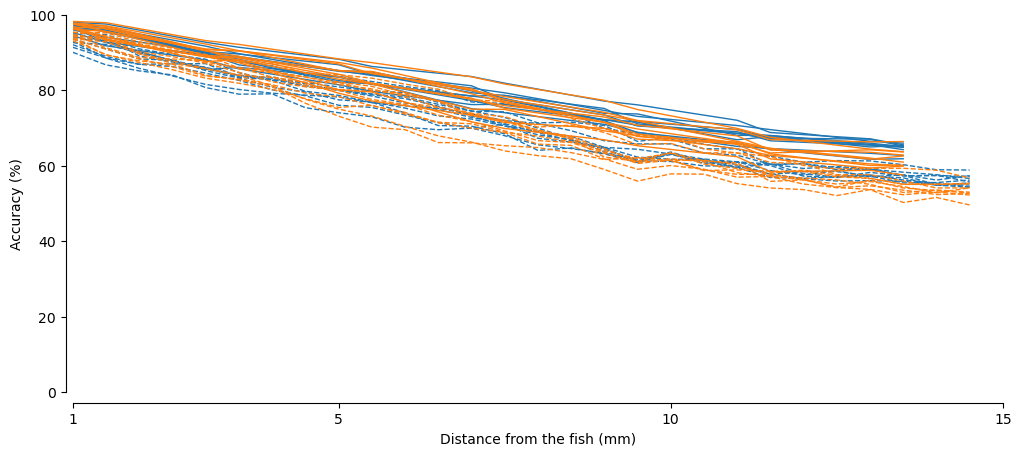

In [18]:
plt.figure(figsize=(12,5))
models.apply(plot_psychometric_curves, axis=1)
plt.ylim(-1,101)
plt.xlim(1,15)
plt.xticks([1, 5, 10, 15])
sns.despine(offset=5, trim=True)
plt.xlabel("Distance from the fish (mm)")
plt.ylabel("Accuracy (%)")
plt.show()

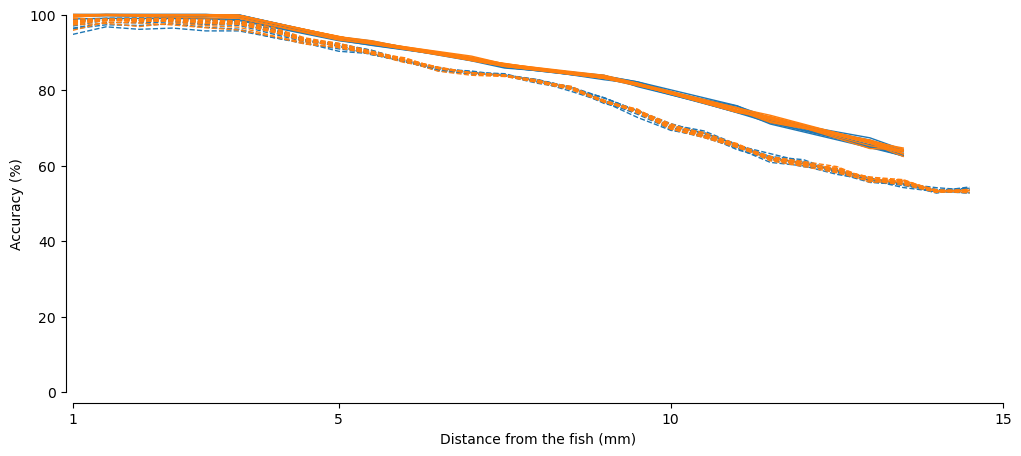

In [23]:
plt.figure(figsize=(12,5))
models.apply(plot_psychometric_curves, axis=1)
plt.ylim(-1,101)
plt.xlim(1,15)
plt.xticks([1, 5, 10, 15])
sns.despine(offset=5, trim=True)
plt.xlabel("Distance from the fish (mm)")
plt.ylabel("Accuracy (%)")
plt.show()

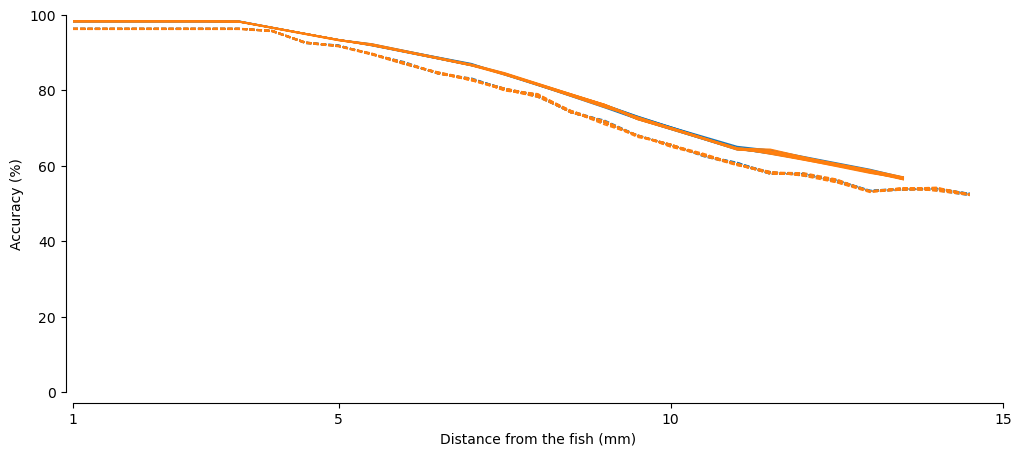

In [28]:
plt.figure(figsize=(12,5))
models.apply(plot_psychometric_curves, axis=1)
plt.ylim(-1,101)
plt.xlim(1,15)
plt.xticks([1, 5, 10, 15])
sns.despine(offset=5, trim=True)
plt.xlabel("Distance from the fish (mm)")
plt.ylabel("Accuracy (%)")
plt.show()

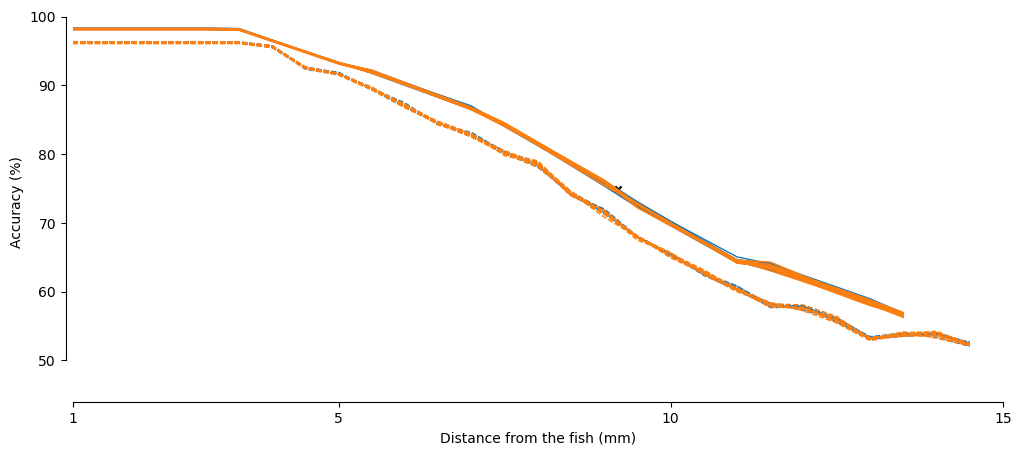

In [29]:
plt.figure(figsize=(12,5))
models.apply(plot_psychometric_curves, axis=1)
plt.ylim(45,101)
plt.xlim(1,15)
plt.xticks([1, 5, 10, 15])
sns.despine(offset=5, trim=True)
plt.xlabel("Distance from the fish (mm)")
plt.ylabel("Accuracy (%)")
plt.scatter([9.2], [75], marker='x', s=20, c='k')
plt.savefig("noise-amount.svg")
plt.show()

In [6]:
raw_dataset["worms"]

{'properties_dict': {'resistances': 0,
  'capacitances': 1,
  'radii': 2,
  'position_xs': 3,
  'position_ys': 4,
  'position_zs': 5},
 'resistances': array([20000., 60000.]),
 'capacitances': array([1.0e-11, 1.5e-09, 7.0e-09]),
 'radii': array([0.0015]),
 'position_xs': array([-0.02]),
 'position_ys': array([0.0115, 0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 ,
        0.0155, 0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 ,
        0.0195, 0.02  , 0.0205, 0.021 , 0.0215, 0.022 , 0.0225, 0.023 ,
        0.0235, 0.024 , 0.0245, 0.025 ]),
 'position_zs': array([0.]),
 'dataframe':      resistances  capacitances  radii  position_xs  position_ys  position_zs
 0              0             0      0            0            0            0
 1              0             0      0            0            1            0
 2              0             0      0            0            2            0
 3              0             0      0            0            3            0
 4     

### Plot 3D electric image of fish

In [50]:
batch_size = 1000
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
raw_dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)

In [51]:
fish = raw_dataset["fish"]["dataframe"]["objs"].iloc[0]

In [52]:
list(enumerate(raw_dataset["worms"]["position_zs"]))

[(0, -0.01),
 (1, -0.008),
 (2, -0.006),
 (3, -0.004),
 (4, -0.002),
 (5, 0.0),
 (6, 0.002),
 (7, 0.004),
 (8, 0.006),
 (9, 0.008),
 (10, 0.01)]

In [65]:
worms_df = raw_dataset["worms"]["dataframe"]
selected_worm = worms_df[
    (worms_df["resistances"] == 2)
    & (worms_df["capacitances"] == 13)
    & (worms_df["radii"] == 13)
    & (worms_df["position_xs"] == 3)
    & (worms_df["position_ys"] == 8)
    & (worms_df["position_zs"] == 5)
]
eis_id = selected_worm.index.item()
eis_id

4477566

In [99]:
fig = fish.visualize_scatter(
    intensity=dset[eis_id][0][0].T.flatten(),
    marker_size=15,
    marker_alpha=1,
    color_map="Viridis",
    fig_width=None,
    fig_height=None,
    xaxis_title="",
    yaxis_title="",
    zaxis_title="",
    show_normals=False,
    show_point_currents=False,
    update_layout=True,
)

In [100]:
fig.update_layout(
    scene=dict(
        xaxis=dict(
            showbackground=False,
            showticklabels=False,
        ),
        yaxis=dict(
            showbackground=False,
            showticklabels=False,
        ),
        zaxis=dict(
            showbackground=False,
            showticklabels=False,
        ),
        xaxis_title="",
        yaxis_title="",
        zaxis_title="",
        aspectmode="data",
    ),
    width=2000,
    height=600,
    margin=dict(r=0, l=0, b=0, t=0),
)
fig.show()

In [125]:
models.iloc[0]["model"].model

EndToEndConvNN2Paths(
  (conv_MZ): Sequential(
    (conv1): Sequential(
      (conv): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 0), padding_mode=circular)
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fun): ReLU()
      (circ_pad): CircularPad2d((0, 0, 1, 1))
      (max_pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (conv): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fun): ReLU()
    )
    (conv3): Sequential(
      (conv): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 0), padding_mode=circular)
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fun): ReLU()
      (circ_pad): CircularPad2d((0, 0, 1, 1))
      (max_pool): MaxPool2d(kernel_size=3, st